### Notebook for analyzing BioCentury Research Farm East Bilsland field site - author @ Matt Nowatzke

In [2]:
import os
import json
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import database as db
import gdal
import rasterio as rio
import analyses.run_apsim
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from rasterstats import zonal_stats
from analyses.munging import get_centroid
from apsim.daymet import create_excel_met
from apsim.apsim_input_writer import create_mukey_runs
from apsim.apsim_output_parser import parse_all_output_field, parse_summary_output_field

### Load management data for 2018 soybeans following corn and 2019 corn following soybeans.

In [22]:
ebilsland_corn_mgmt_2018 = json.loads( open( 'crop_jsons/ebilsland_cfs_2018.json', 'r' ).read() )
ebilsland_soy_mgmt_2019 = json.loads( open( 'crop_jsons/ebilsland_sfc_2019.json', 'r' ).read() )

In [ ]:
ebilsland_soy_mgmt_2019

### Create database connection and get a list of all the unique soils (mukeys) for the field.  
Each soil mapunit has unique musym identifier and a mapunit key (mukey) which relates to soil properties.

In [23]:
dbconn = db.connect_to_db('database.ini')

In [24]:
#with turn rows
#ebilsland_ssurgo = gpd.read_file("C:/Users/mjn/Documents/Foresite/yield_monitor_data/analyses/ebilsland/ebilsland_ssurgo_2019.geojson")

#without turn rows
ebilsland_ssurgo = gpd.read_file("C:\\Users\\mjn\\Documents\\Foresite\\yield_monitor_data\\analyses\\ebilsland\\ssurgo\\noturnrows\\ebilsland_ssurgo_noturnrows.geojson")
ebilsland_mukeys = list(np.unique(ebilsland_ssurgo['mukey']))
ebilsland_mukeys

['2550285', '2765522', '2834849', '2835012', '2835146', '2922007']

### Get the centroid of the field and create met file.
This met file--if created on a Windows machine--is a an Excel file that should be saved afterwards as a Formatted Text file (*.prn)  
See: https://www.apsim.info/support/apsim-training-manuals/creating-an-apsim-met-file-using-excel/  
This is a known problem with Pandas on Windows. If creating the met file on Mac or Linux, feel free to use the daymet.create_met function instead.

In [ ]:
ebilsland_centroid = get_centroid(ebilsland_ssurgo, 'areasymbol', 'geometry')
create_excel_met(ebilsland_centroid[0], ebilsland_centroid[1], 2012, 2019, 'Ebilsland')
print(f'East Bilsland centroid located at {ebilsland_centroid}')

### Create runs using the default soil calcs or Saxton Rawls

In [25]:
create_mukey_runs(ebilsland_mukeys, dbconn, 'cfs', 'Ebilsland.met', 'EbilslandDefault', start_year=2016, end_year=2018, sfc_mgmt=ebilsland_soy_mgmt_2019, cfs_mgmt=ebilsland_corn_mgmt_2018)
create_mukey_runs(ebilsland_mukeys, dbconn, 'cfs', 'Ebilsland.met', 'EbilslandSaxton', start_year=2016, end_year=2018, sfc_mgmt=ebilsland_soy_mgmt_2019, cfs_mgmt=ebilsland_corn_mgmt_2018, saxton=True)

Finished! All files created!
Finished! All files created!


In [ ]:
create_mukey_runs(ebilsland_mukeys, dbconn, 'sfc', 'Ebilsland.met', 'EbilslandDefault', start_year=2017, end_year=2019, sfc_mgmt=ebilsland_soy_mgmt_2019, cfs_mgmt=ebilsland_corn_mgmt_2018)
create_mukey_runs(ebilsland_mukeys, dbconn, 'sfc', 'Ebilsland.met', 'EbilslandSaxton', start_year=2017, end_year=2019, sfc_mgmt=ebilsland_soy_mgmt_2019, cfs_mgmt=ebilsland_corn_mgmt_2018, saxton=True)

### Run simulations

In [26]:
analyses.run_apsim.run_all_simulations(apsim_files_path="apsim_files\\EbilslandSaxton\\2018\\cfs\\*.apsim", sim_files_path="apsim_files\\EbilslandSaxton\\2018\\cfs\\*.sim")
analyses.run_apsim.run_all_simulations(apsim_files_path="apsim_files\\EbilslandSaxton\\2019\\sfc\\*.apsim", sim_files_path="apsim_files\\EbilslandSaxton\\2019\\sfc\\*.sim")

Running on 62 cores
Converting 6 .apsim files to .sim files.
Running Apsim for 6 .sim files...
Runs completed.
Processing time: 2.0978 seconds
Running on 62 cores
Converting 6 .apsim files to .sim files.
Running Apsim for 6 .sim files...
Runs completed.
Processing time: 2.0763 seconds


In [27]:
analyses.run_apsim.run_all_simulations(apsim_files_path="apsim_files\\EbilslandDefault\\2018\\cfs\\*.apsim", sim_files_path="apsim_files\\EbilslandDefault\\2018\\cfs\\*.sim")
analyses.run_apsim.run_all_simulations(apsim_files_path="apsim_files\\EbilslandDefault\\2019\\sfc\\*.apsim", sim_files_path="apsim_files\\EbilslandDefault\\2019\\sfc\\*.sim")

Running on 62 cores
Converting 6 .apsim files to .sim files.
Running Apsim for 6 .sim files...
Runs completed.
Processing time: 2.0775 seconds
Running on 62 cores
Converting 6 .apsim files to .sim files.
Running Apsim for 6 .sim files...
Runs completed.
Processing time: 2.0773 seconds


### View output from APSIM runs for default soil profiles and saxton soil profiles.

In [3]:
ebilsland_maize_output_2018_saxton = parse_summary_output_field("apsim_files/EbilslandSaxton/2018/cfs", year=2018)
ebilsland_maize_output_2018_saxton

,title,field,mukey,rotation,year,soybean_yield,maize_yield,corn_buac,soy_buac,soybean_biomass,maize_biomass,fertiliser,surfaceom_c_init,surfaceom_c_end,leach_no3
0,name_EbilslandSaxton_mukey_2550285_rot_cfs_sim,EbilslandSaxton,2550285,cfs,2018,0.0,11115.71231,207.92920,0.0,0.0,22274.53618,0.0,3143.54565,3963.31128,56.77211
1,name_EbilslandSaxton_mukey_2765522_rot_cfs_sim,EbilslandSaxton,2765522,cfs,2018,0.0,10653.64283,199.28578,0.0,0.0,18639.39271,0.0,2719.90137,3344.28955,17.81767
2,name_EbilslandSaxton_mukey_2834849_rot_cfs_sim,EbilslandSaxton,2834849,cfs,2018,0.0,10826.95052,202.52766,0.0,0.0,20022.21699,0.0,2751.22778,3558.39185,19.03100
3,name_EbilslandSaxton_mukey_2835012_rot_cfs_sim,EbilslandSaxton,2835012,cfs,2018,0.0,11008.79361,205.92920,0.0,0.0,21369.69468,0.0,2920.02612,3797.53564,25.75259
4,name_EbilslandSaxton_mukey_2835146_rot_cfs_sim,EbilslandSaxton,2835146,cfs,2018,0.0,11023.33863,206.20128,0.0,0.0,21464.89756,0.0,2939.08691,3808.51147,29.33317
5,name_EbilslandSaxton_mukey_2922007_rot_cfs_sim,EbilslandSaxton,2922007,cfs,2018,0.0,10926.07924,204.38196,0.0,0.0,20851.77502,0.0,2799.58106,3700.61841,22.68160


In [4]:
ebilsland_soy_output_2019_saxton = parse_summary_output_field("apsim_files/EbilslandSaxton/2019/sfc", year=2019)
ebilsland_soy_output_2019_saxton

,title,field,mukey,rotation,year,soybean_yield,maize_yield,corn_buac,soy_buac,soybean_biomass,maize_biomass,fertiliser,surfaceom_c_init,surfaceom_c_end,leach_no3
0,name_EbilslandSaxton_mukey_2550285_rot_sfc_sim,EbilslandSaxton,2550285,sfc,2019,3599.92529,0.0,0.0,61.65389,7517.64648,0.0,0.0,4154.16602,2927.83301,181.30395
1,name_EbilslandSaxton_mukey_2765522_rot_sfc_sim,EbilslandSaxton,2765522,sfc,2019,3563.99170,0.0,0.0,61.03848,7451.83838,0.0,0.0,3924.59033,2904.33130,64.70263
2,name_EbilslandSaxton_mukey_2834849_rot_sfc_sim,EbilslandSaxton,2834849,sfc,2019,3570.76196,0.0,0.0,61.15443,7466.08887,0.0,0.0,3900.15210,2908.31299,85.17977
3,name_EbilslandSaxton_mukey_2835012_rot_sfc_sim,EbilslandSaxton,2835012,sfc,2019,3598.39844,0.0,0.0,61.62774,7515.35449,0.0,0.0,3976.50024,2927.63013,126.30414
4,name_EbilslandSaxton_mukey_2835146_rot_sfc_sim,EbilslandSaxton,2835146,sfc,2019,3599.11523,0.0,0.0,61.64002,7516.80518,0.0,0.0,4043.63647,2927.95606,130.95341
5,name_EbilslandSaxton_mukey_2922007_rot_sfc_sim,EbilslandSaxton,2922007,sfc,2019,3581.55615,0.0,0.0,61.33929,7485.22461,0.0,0.0,3912.94385,2915.62817,106.92022


In [5]:
#ebilsland_soy_output_2019_saxton.to_csv('ebilsland_saxton_soy_2019.csv', index=False)

In [6]:
ebilsland_maize_output_2018_default = parse_summary_output_field("apsim_files/EbilslandDefault/2018/cfs", year=2018)
ebilsland_maize_output_2018_default

,title,field,mukey,rotation,year,soybean_yield,maize_yield,corn_buac,soy_buac,soybean_biomass,maize_biomass,fertiliser,surfaceom_c_init,surfaceom_c_end,leach_no3
0,name_EbilslandDefault_mukey_2550285_rot_cfs_sim,EbilslandDefault,2550285,cfs,2018,0.0,11071.41488,207.10059,0.0,0.0,21639.33261,0.0,2689.70923,3851.14746,26.03907
1,name_EbilslandDefault_mukey_2765522_rot_cfs_sim,EbilslandDefault,2765522,cfs,2018,0.0,10817.48608,202.35062,0.0,0.0,19851.85332,0.0,3049.76294,3587.55298,9.11150
2,name_EbilslandDefault_mukey_2834849_rot_cfs_sim,EbilslandDefault,2834849,cfs,2018,0.0,10845.64575,202.87738,0.0,0.0,20227.17789,0.0,3006.84106,3621.39575,10.15412
3,name_EbilslandDefault_mukey_2835012_rot_cfs_sim,EbilslandDefault,2835012,cfs,2018,0.0,10938.14469,204.60765,0.0,0.0,21072.45429,0.0,3003.70068,3756.31763,14.90942
4,name_EbilslandDefault_mukey_2835146_rot_cfs_sim,EbilslandDefault,2835146,cfs,2018,0.0,10942.22415,204.68396,0.0,0.0,21241.78760,0.0,3105.90967,3790.79810,15.66696
5,name_EbilslandDefault_mukey_2922007_rot_cfs_sim,EbilslandDefault,2922007,cfs,2018,0.0,10888.28867,203.67505,0.0,0.0,20662.17534,0.0,2978.63623,3685.51904,10.69089


In [7]:
ebilsland_soy_output_2019_default = parse_summary_output_field("apsim_files/EbilslandDefault/2019/sfc", year=2019)
ebilsland_soy_output_2019_default

,title,field,mukey,rotation,year,soybean_yield,maize_yield,corn_buac,soy_buac,soybean_biomass,maize_biomass,fertiliser,surfaceom_c_init,surfaceom_c_end,leach_no3
0,name_EbilslandDefault_mukey_2550285_rot_sfc_sim,EbilslandDefault,2550285,sfc,2019,3534.75366,0.0,0.0,60.53773,7387.10986,0.0,0.0,3933.40186,2876.97314,118.31692
1,name_EbilslandDefault_mukey_2765522_rot_sfc_sim,EbilslandDefault,2765522,sfc,2019,3599.92481,0.0,0.0,61.65388,7517.64600,0.0,0.0,4061.56665,2931.43115,67.95033
2,name_EbilslandDefault_mukey_2834849_rot_sfc_sim,EbilslandDefault,2834849,sfc,2019,3599.78857,0.0,0.0,61.65155,7517.50439,0.0,0.0,4027.91357,2929.90649,74.59351
3,name_EbilslandDefault_mukey_2835012_rot_sfc_sim,EbilslandDefault,2835012,sfc,2019,3598.90283,0.0,0.0,61.63638,7516.58447,0.0,0.0,4009.78980,2929.08887,103.86300
4,name_EbilslandDefault_mukey_2835146_rot_sfc_sim,EbilslandDefault,2835146,sfc,2019,3599.92481,0.0,0.0,61.65388,7517.64600,0.0,0.0,4044.78980,2929.55273,106.75616
5,name_EbilslandDefault_mukey_2922007_rot_sfc_sim,EbilslandDefault,2922007,sfc,2019,3599.03101,0.0,0.0,61.63858,7516.71728,0.0,0.0,4008.33984,2929.16919,78.19918


In [33]:
#ebilsland_soy_output_2019_default.to_csv("output/apsim/ebilsland_apsim_default_soy_2019.csv", index=False)
#ebilsland_maize_output_2018_default.to_csv("output/apsim/ebilsland_apsim_default_maize_2018.csv", index=False)

Get zonal stats from yield monitor data to compare to simulated yields

In [8]:
#With turn rows included
# ebilsland_raster = "C:\\Users\\mjn\\Documents\\Foresite\\yield_monitor_data\\analyses\\ebilsland\\ebilsland_soy_2019_raster_30.tif"
# ebilsland_ssurgo_geojson = 'C:/Users/mjn/Documents/Foresite/yield_monitor_data/analyses/ebilsland/ebilsland_ssurgo_2019.geojson'

#Removed turn rows
ebilsland_raster = "C:\\Users\\mjn\\Documents\\Foresite\\yield_monitor_data\\analyses\\ebilsland\\yield_monitor\\noturnrows\\ebilsland_soy_2019_raster_30_noturnrows.tif"
ebilsland_ssurgo_geojson = "C:\\Users\\mjn\\Documents\\Foresite\\yield_monitor_data\\analyses\\ebilsland\\ssurgo\\noturnrows\\ebilsland_ssurgo_noturnrows.geojson"

In [ ]:
stats = zonal_stats(ebilsland_ssurgo_geojson, ebilsland_raster, geojson_out=True, stats=['min', 'max', 'median', 'mean', 'std', 'range'])

In [ ]:
ebilsland_soy_2019_stats = gpd.GeoDataFrame.from_features(stats)

In [ ]:
ebilsland_soy_2019_stats

In [ ]:
ebilsland_soy_ym = ebilsland_soy_2019_stats[['geometry', 'Field', 'objectid', 'areasymbol', 'musym', 'mukey', 'shape_area', 'mean', 'median', 'min', 'max', 'std', 'range']]
ebilsland_soy_ym.sort_values('mukey')

In [ ]:
ebilsland_soy_ym = ebilsland_soy_ym.drop(index=7)

In [ ]:
ebilsland_soy_ym = ebilsland_soy_ym.round({'mean':2,'median':2, 'min':2, 'max':2, 'std':2, 'range':2})

In [ ]:
ebilsland_soy_ym

In [ ]:
#Write summary stats file to json for first time.
#ebilsland_soy_ym.to_file("output/ebilsland_zonalstats_soy_2019.geojson", driver='GeoJSON')

In [ ]:
ebilsland_raster_maize = "C:\\Users\\mjn\\Documents\\Foresite\\yield_monitor_data\\analyses\\ebilsland\\yield_monitor\\noturnrows\\ebilsland_soy_2019_raster_30_noturnrows.tif"

In [9]:
#Read summary stats file from json.
ebilsland_soy_ym = gpd.read_file("output/ym/ebilsland_zonalstats_soy_2019.geojson")

In [10]:
def wkb_hexer(line):
    return line.wkb_hex

In [11]:
ebilsland_soy_ym['geometry'] = ebilsland_soy_ym['geometry'].apply(wkb_hexer)

In [12]:
ebilsland_pd = pd.DataFrame(ebilsland_soy_ym)

In [ ]:
db_schema = 'biocent_farms'
db_table = 'ebilsland_soy_2019_yield_zonal_stats' 
ebilsland_pd.to_sql(
con = dbconn,
name = db_table,
schema = db_schema,
if_exists = 'replace',
index = False,
chunksize=1000,
method='multi' )

#### Get distribution of observed yields

In [ ]:
with rio.open(ebilsland_raster) as src:
    ebilsland_raster_hist = src.read(1, masked=True)
ebilsland_raster_hist = ebilsland_raster_hist.ravel()

In [ ]:
plt.hist(ebilsland_raster_hist,
        bins=[10,20,30,40,50,60,70,80,90,100],
        color='purple')
plt.xlabel('Soybean yield')
plt.ylabel('Frequency')
plt.title('East Bilsland 2019 Soybean Yield')
plt.show()

![SSURGO soils with raster yield overlay](images/ebilsland_ssurgo_w_rasteryield.png "East Bilsland SSURGO soils with yield overlay")  

## Get predicted vs observed  
Filter the data and left join to get df of default soil prediction vs. observed mean and Saxton soil bs observed mean.

In [13]:
#get yield monitor data
ebilsland_soy_ym = ebilsland_soy_ym[['geometry','objectid', 'mukey', 'mean']]

In [14]:
#get predictions
default_apsim_pred = ebilsland_soy_output_2019_default[['mukey', 'soy_buac']]
saxton_apsim_pred = ebilsland_soy_output_2019_saxton[['mukey', 'soy_buac']]

In [16]:
#merge to compare
pred_vs_obs_saxton = ebilsland_soy_ym.merge(saxton_apsim_pred, on='mukey', how='left')
pred_vs_obs_saxton.columns = ['geometry','objectid', 'mukey', 'observed', 'predicted']
pred_vs_obs_saxton['resid'] = pred_vs_obs_saxton['predicted'] - pred_vs_obs_saxton['observed']
pred_vs_obs_saxton.sort_values('mukey')
pred_vs_obs_default = ebilsland_soy_ym.merge(default_apsim_pred, on='mukey', how='left')
pred_vs_obs_default.columns = ['geometry','objectid', 'mukey', 'observed', 'predicted']
pred_vs_obs_default['resid'] = pred_vs_obs_default['predicted'] - pred_vs_obs_default['observed']
pred_vs_obs_default.sort_values('mukey')

,geometry,objectid,mukey,observed,predicted,resid
0,0106000000010000000103000000010000001A0000000D...,13447276,2550285,54.85,60.53773,5.68773
2,0106000000010000000103000000010000001700000065...,13455735,2765522,57.86,61.65388,3.79388
3,0106000000010000000103000000010000003B00000079...,13458179,2765522,59.02,61.65388,2.63388
4,01060000000100000001030000000100000010000000D5...,13458216,2765522,42.74,61.65388,18.91388
5,0106000000010000000103000000010000000A00000043...,13458451,2765522,65.46,61.65388,-3.80612
6,01060000000100000001030000000100000061000000BB...,13461421,2765522,62.06,61.65388,-0.40612
9,01060000000100000001030000000100000012000000A7...,13470727,2834849,57.68,61.65155,3.97155
10,0106000000010000000103000000010000000A000000C8...,13471951,2834849,52.51,61.65155,9.14155
11,01060000000200000001030000000100000004000000F9...,13472028,2834849,47.02,61.65155,14.63155
1,0106000000010000000103000000010000000D00000018...,13449079,2835012,65.52,61.63638,-3.88362


In [17]:
pred_vs_obs_default.to_csv("output/fit/ebilsland_pvo_soy_2019.csv", index=False)

In [36]:
pred_vs_obs_default

,geometry,objectid,mukey,observed,predicted,resid
0,0106000000010000000103000000010000001A0000000D...,13447276,2550285,54.85,60.53773,5.68773
1,0106000000010000000103000000010000000D00000018...,13449079,2835012,65.52,61.63638,-3.88362
2,0106000000010000000103000000010000001700000065...,13455735,2765522,57.86,61.65388,3.79388
3,0106000000010000000103000000010000003B00000079...,13458179,2765522,59.02,61.65388,2.63388
4,01060000000100000001030000000100000010000000D5...,13458216,2765522,42.74,61.65388,18.91388
5,0106000000010000000103000000010000000A00000043...,13458451,2765522,65.46,61.65388,-3.80612
6,01060000000100000001030000000100000061000000BB...,13461421,2765522,62.06,61.65388,-0.40612
7,0106000000010000000103000000010000002200000040...,13466907,2922007,62.84,61.63858,-1.20142
8,01060000000900000001030000000100000008000000E8...,13467687,2922007,60.89,61.63858,0.74858
9,01060000000100000001030000000100000012000000A7...,13470727,2834849,57.68,61.65155,3.97155


## Results from 'default' soil calculations

Round the buac and store in tuples to preserve order for comparison.

In [38]:
yield_monitor = tuple(pred_vs_obs_default['observed'])
yield_monitor = [round(num, 2) for num in yield_monitor]
def_apsim_predicted = tuple(pred_vs_obs_default['predicted'])
def_apsim_predicted = [round(num, 2) for num in def_apsim_predicted]

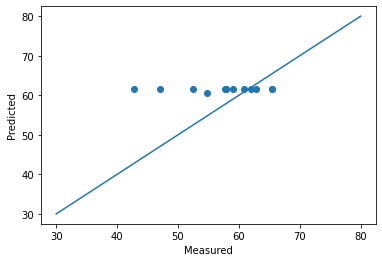

In [39]:
fig, ax = plt.subplots()
ax.scatter(yield_monitor, def_apsim_predicted)
ax.plot([30,80],[30,80])
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
sns.set(style="whitegrid")
sns.residplot(def_apsim_predicted, yield_monitor)

In [ ]:
rmse = mean_squared_error(yield_monitor, def_apsim_predicted, squared=False)
rmse

In [ ]:
r_sq = r2_score(yield_monitor, def_apsim_predicted)
r_sq

In [ ]:
corr_matrix = np.corrcoef(yield_monitor, def_apsim_predicted)
corr_xy = corr_matrix[0,1]
r_squared = corr_xy**2
r_squared

### Saxton results

In [ ]:
yield_monitor = tuple(pred_vs_obs_saxton['observed'])
yield_monitor = [round(num, 2) for num in yield_monitor]
sax_apsim_predicted = tuple(pred_vs_obs_saxton['predicted'])
sax_apsim_predicted = [round(num, 2) for num in sax_apsim_predicted]

In [ ]:
fig, ax = plt.subplots()
ax.scatter(yield_monitor, sax_apsim_predicted)
ax.plot([30,80],[30,80])
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
rmse = mean_squared_error(yield_monitor, sax_apsim_predicted, squared=False)
rmse

In [ ]:
r_sq = r2_score(yield_monitor, sax_apsim_predicted)
r_sq

In [ ]:
corr_matrix = np.corrcoef(yield_monitor, sax_apsim_predicted)
corr_xy = corr_matrix[0,1]
r_squared = corr_xy**2
r_squared